In [67]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import datetime as dt

In [68]:
symbol = input("Enter the code of the stock:")

Enter the code of the stock:FB


In [69]:
df = web.DataReader(symbol , 'yahoo', start='2021-01-02', end='2022-03-23')

In [70]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-01-04,275.000000,265.200012,274.779999,268.940002,15106100,268.940002
2021-01-05,272.399994,268.209991,268.290009,270.970001,9871600,270.970001
2021-01-06,267.750000,260.010010,262.000000,263.309998,24354100,263.309998
2021-01-07,271.609985,264.779999,265.899994,268.739990,15789800,268.739990
2021-01-08,268.950012,263.179993,268.309998,267.570007,18528300,267.570007


In [71]:
df1 =  df.reset_index()['Open']

In [72]:
df1.head()

0    274.779999
1    268.290009
2    262.000000
3    265.899994
4    268.309998
Name: Open, dtype: float64

In [73]:
df1.shape

(308,)

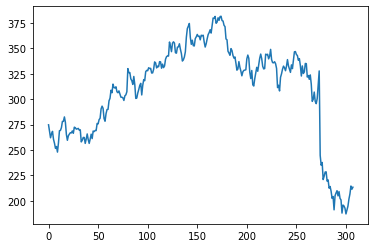

In [74]:
import matplotlib.pyplot as plt
plt.plot(df1)

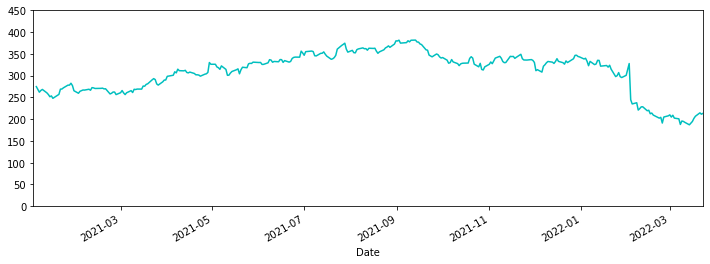

In [75]:
df['Open'].plot(xlim=['2021-01-02','2022-03-23'],ylim=[0,450],figsize=(12,4),color='c',ls='-')

### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [76]:
df1


0      274.779999
1      268.290009
2      262.000000
3      265.899994
4      268.309998
          ...    
303    201.699997
304    206.699997
305    214.500000
306    211.369995
307    213.330002
Name: Open, Length: 308, dtype: float64

In [77]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [78]:
df1.shape

(308, 1)

In [79]:
##Splitting dataset into train and test
training_size = int(len(df1)*0.65)
test_size = len(df1) - training_size
train_data,test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [80]:
len(df1)

308

In [81]:
len(train_data)

200

In [82]:
len(test_data)

108

In [83]:
training_size,test_size

(200, 108)

In [84]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [85]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
import numpy 
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [86]:
print(X_train)

[[0.45080916 0.41746731 0.38515286 ... 0.41757    0.37734403 0.3575649 ]
 [0.41746731 0.38515286 0.40518879 ... 0.37734403 0.3575649  0.33146677]
 [0.38515286 0.40518879 0.41757    ... 0.3575649  0.33146677 0.34097096]
 ...
 [0.76290781 0.72720263 0.73316206 ... 0.74225541 0.72232217 0.69868998]
 [0.72720263 0.73316206 0.77045983 ... 0.72232217 0.69868998 0.71893145]
 [0.73316206 0.77045983 0.74225541 ... 0.69868998 0.71893145 0.72607239]]


In [87]:
print(X_train.shape), print(y_train.shape)

(192, 7)
(192,)


(None, None)

In [88]:
print(X_test.shape), print(ytest.shape)

(100, 7)
(100,)


(None, None)

In [89]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [90]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [91]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(7,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',metrics='mse',optimizer='adam')

In [92]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 50)             10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 50)             20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [93]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
3/3 [==============================] - 4s 552ms/step - loss: 0.4599 - mse: 0.4599 - val_loss: 0.2700 - val_mse: 0.2700
Epoch 2/100
3/3 [==============================] - 0s 23ms/step - loss: 0.3383 - mse: 0.3383 - val_loss: 0.1742 - val_mse: 0.1742
Epoch 3/100
3/3 [==============================] - 0s 23ms/step - loss: 0.2017 - mse: 0.2017 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 4/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0652 - mse: 0.0652 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 5/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.1032 - val_mse: 0.1032
Epoch 6/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0628 - mse: 0.0628 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 7/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0244 - mse: 0.0244 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 8/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0102 - mse: 0.0

In [94]:
model.evaluate(X_test,ytest)

4/4 [==============================] - 0s 5ms/step - loss: 0.0134 - mse: 0.0134


[0.013443737290799618, 0.013443737290799618]

In [95]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [96]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [97]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

321.0234057140261

In [98]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

303.26273304602574

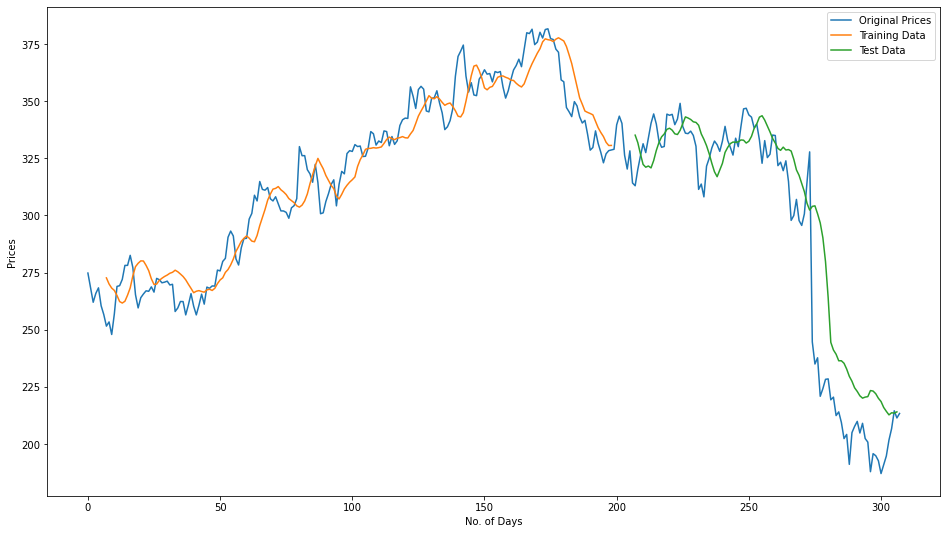

In [99]:
### Plotting 
# shift train predictions for plotting
look_back=7
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.figure(figsize=(16,9))
plt.xlabel('No. of Days')
plt.ylabel('Prices')
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Original Prices','Training Data','Test Data'])
plt.show()

In [100]:
len(test_data)

108

In [101]:
108-7 ## here we see that since for predicting the open price of 19thJan 2022,we will use past 100 records to predict the price on jan 19th


101

In [102]:
x_input=test_data[101:].reshape(1,-1)
x_input.shape


(1, 7)

In [103]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [104]:
temp_input

[0.01936811914037795,
 0.03940405039531758,
 0.07536603456944813,
 0.10105316612239867,
 0.14112510702318215,
 0.12504493758594581,
 0.13511432764670028]

In [105]:
# demonstrate prediction for next 7 days since we have previous sentiments for past one week scrapped from the live data
from numpy import array

lst_output=[]
n_steps=7
i=0
while(i<7):
    
    if(len(temp_input)>7):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.16373748]
8
1 day input [0.03940405 0.07536603 0.10105317 0.14112511 0.12504494 0.13511433
 0.16373748]
1 day output [[0.18082757]]
2 day input [0.07536603 0.10105317 0.14112511 0.12504494 0.13511433 0.16373748
 0.18082757]
2 day output [[0.19782986]]
3 day input [0.10105317 0.14112511 0.12504494 0.13511433 0.16373748 0.18082757
 0.19782986]
3 day output [[0.21147557]]
4 day input [0.14112511 0.12504494 0.13511433 0.16373748 0.18082757 0.19782986
 0.21147557]
4 day output [[0.22339477]]
5 day input [0.12504494 0.13511433 0.16373748 0.18082757 0.19782986 0.21147557
 0.22339477]
5 day output [[0.23056422]]
6 day input [0.13511433 0.16373748 0.18082757 0.19782986 0.21147557 0.22339477
 0.23056422]
6 day output [[0.24366674]]
[[0.1637374758720398], [0.1808275729417801], [0.19782985746860504], [0.21147556602954865], [0.22339476644992828], [0.23056422173976898], [0.24366673827171326]]


In [106]:
day_new=np.arange(1,8)
day_pred=np.arange(8,15)

In [107]:
day_new.shape

(7,)

In [108]:
import matplotlib.pyplot as plt

In [109]:
len(df1)

308

In [110]:
308-7 ##since we are predicting 7 day prices ,based on previous 7 records

301

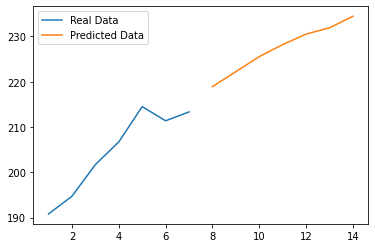

In [111]:
plt.plot(day_new,scaler.inverse_transform(df1[301:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
plt.legend(['Real Data','Predicted Data'])
plt.show()

In [112]:
## After combining both the actual data and the predicted data just to smoothen the graph,

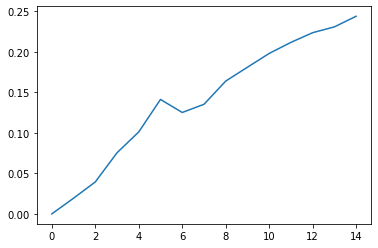

In [113]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[300:])

plt.show()
